In [42]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){$('div.input').hide();} else {$('div.input').show();}
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Toggle code (clean for GitHub)</a>''')

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv("C:/Users/alber/Desktop/PROJECT FILES/HR Data/HR IBM - ML project/IBM HR Analytics Employee Attrition & Performance.csv")
print(f"✅ Loaded {len(df)} employees")



✅ Loaded 1470 employees


PREPARING DATA

In [31]:
y = (df['Attrition'] == 'Yes').astype(int)
X = df.drop(['Attrition', 'EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], axis=1)

ENCODE CATEGORICAL VARIABLES

In [32]:
for col in X.select_dtypes('object'):
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

LOGISTIC REGRESSION

In [33]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
print(" LR AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

 LR AUC: 0.7626841243862521


c:\Users\alber\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RANDOM FOREST

In [34]:
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf.fit(X_train, y_train)
print(" RF AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


 RF AUC: 0.8109225600826944


XG BOOST AND SHAP

In [35]:
import xgboost as xgb
import shap

scale = len(y_train) / (2 * y_train.sum())  # ~3.5 if attrition ~22%
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
print(f" XGBoost AUC: {xgb_auc:.3f}")



 XGBoost AUC: 0.779


SHAP Explanation 

C:\Users\alber\AppData\Local\Temp\ipykernel_41008\1533895656.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


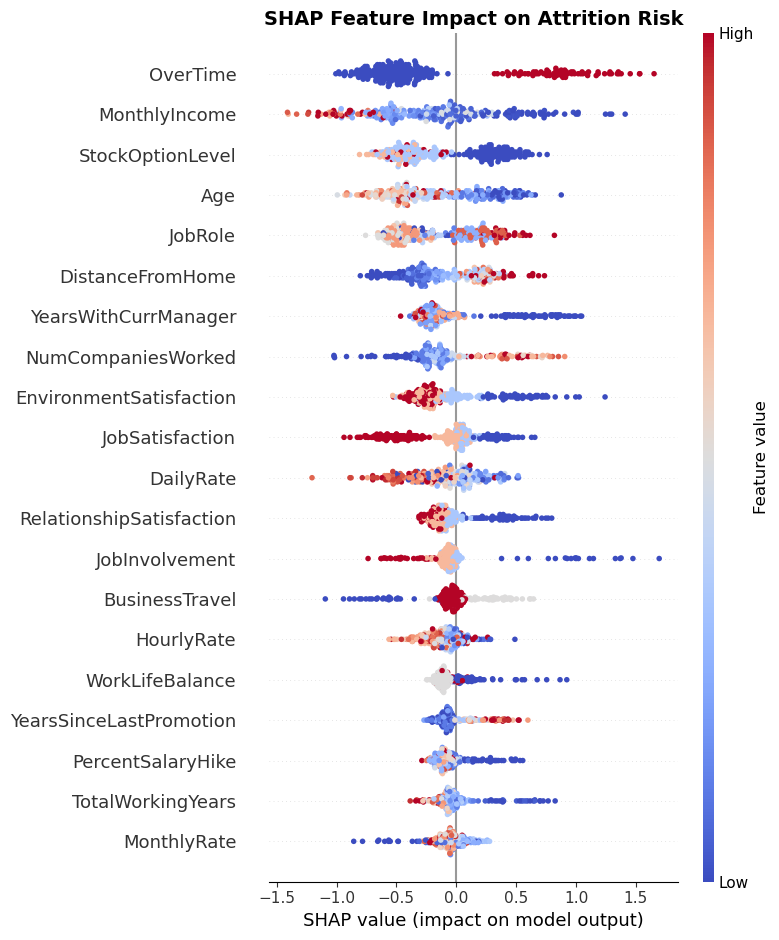

In [36]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot — clean, publication-ready
plt.figure(figsize=(9,6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, 
                  plot_type="dot", 
                  show=False,
                  color_bar_label="Feature value",
                  cmap="coolwarm")
plt.title("SHAP Feature Impact on Attrition Risk", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

SHAP Insights — What HR Should Know
# - Red = high feature value → pushes toward attrition  
# - Blue = low feature value → pushes toward retention  
# - Horizontal spread = impact strength

In [37]:
import numpy as np
shap_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False).head(10)

print("📊 Top 10 Global SHAP Drivers (Magnitude of Impact):")
print(shap_df.to_string(index=False))

# Example: Show how one employee's risk breaks down


📊 Top 10 Global SHAP Drivers (Magnitude of Impact):
                feature  mean_abs_shap
               OverTime       0.619089
          MonthlyIncome       0.440293
       StockOptionLevel       0.375052
                    Age       0.373785
                JobRole       0.330925
       DistanceFromHome       0.292347
   YearsWithCurrManager       0.289926
     NumCompaniesWorked       0.285573
EnvironmentSatisfaction       0.276170
        JobSatisfaction       0.254273


TOP 10 DRIVERS OF ATTRITION GRAPH

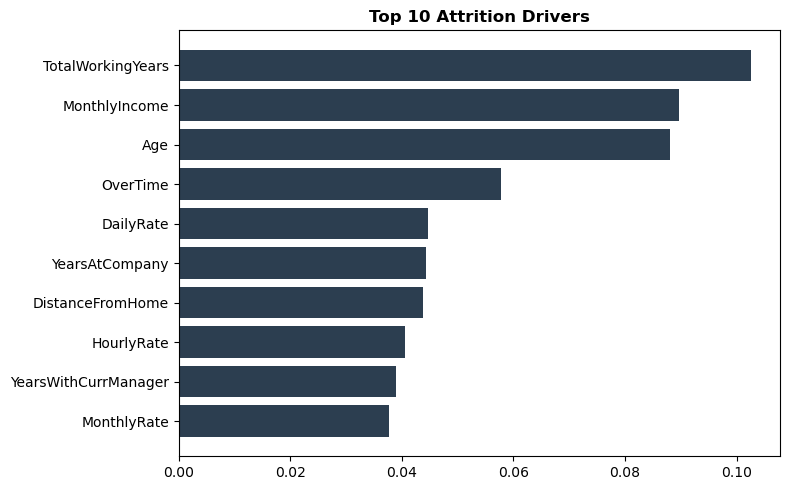

In [38]:
top10 = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).nlargest(10, 'importance')

plt.figure(figsize=(8,5))
plt.barh(top10['feature'], top10['importance'], color='#2C3E50')
plt.gca().invert_yaxis()
plt.title('Top 10 Attrition Drivers', fontweight='bold')
plt.tight_layout()
plt.show()